Les bibliothèques à installer

In [ ]:
!pip install transformers
!pip install unidecode
!pip install emoji
!pip install SentencePiece
!pip install captum
!pip install scikit-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.1 MB/s eta 0:00:00


Import Library

In [ ]:
import pandas as pd
import torch
from torch import nn
from tqdm import tqdm, trange
import numpy as np
import json
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertTokenizer, CamembertForSequenceClassification
from transformers import AdamW
import json
import re
from bs4 import BeautifulSoup
import unidecode
import emoji
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from captum.attr import LayerIntegratedGradients
from captum.attr import visualization as viz
from collections import defaultdict
import scikitplot as skplt
import matplotlib.pyplot as plt
from transformers import CamembertModel

In [ ]:
pip install --upgrade emoji

Partie 1 : Preprocess Data

In [ ]:
def process_json_file(filename):
    # Open and read the JSON file
    with open(filename, 'r', encoding='utf-8') as file:
        data = json.load(file)

    # Create an empty list to store the rows
    rows = []

    # Iterate over each key-value pair in the JSON data
    for key, value in data.items():
        # Extract the required fields from the value
        topic = value.get('topic')
        stance = value.get('stance')
        text = value.get('text')
        author = value.get('author')

        # Create a row as a list with the extracted fields
        row = [topic, stance, text, author]

        # Add the row to the list of rows
        rows.append(row)

    # Create the DataFrame using the list of rows
    df = pd.DataFrame(rows, columns=['Topic', 'Stance', 'Text', 'Author'])
    # Remove "Stance" and "Author" columns
    df = df.drop(['Stance', 'Author'], axis=1)

    # Rearrange the columns
    df = df[['Text', 'Topic']]
    df = df[df['Topic'] != 'other']
    df['Topic'] = df['Topic'].replace('nucleaire', 'nucléaire')

    return df

# Call the function with the filename and print the result
df = process_json_file('results.json')
df

,Text,Topic
0,🇸🇬 Un ancien Airbus A380 de Singapore Airlines...,avion
1,Deux Dassault Falcon 900LX pour la Royal Air F...,avion
2,🔴 Israël vient d'annoncer l'interdiction des v...,avion
3,Mais ce volet là est particulièrement importan...,décroissance
4,"Ce n’est pas le cas de #Malte, qui a peu de pl...",nucléaire
...,...,...
492,On a été dans un des seuls resto un peu gastro...,viande
494,@BShirizadeh @rogerseban @BridonneauV @Reclaim...,nucléaire
495,"La baisse des émissions carbone, c'est l'élect...",nucléaire
497,Dans une nouvelle enquête #L214 montre des cas...,viande


In [ ]:


def convert_emoji_to_text(input_text):
    french_stopwords = ['le', 'la', 'les', 'de', 'du', 'des', 'je', 'tu', 'il', 'elle', 'nous', 'vous', 'ils', 'elles']

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', input_text)
    text = emoji.demojize(text)

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove non-alphanumeric characters except for certain characters that may form complete words
    text = re.sub(r"[^\wÀ-ÿ\s'-]", '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    # Convert accented characters to their ASCII equivalent
    converted_text = unidecode.unidecode(text)

    # Convert emojis to text representation


    # Remove words that don't have any sense in French
    converted_text = ' '.join([word for word in converted_text.split() if word.lower() not in french_stopwords])

    return converted_text
df['Text'] = df['Text'].apply(convert_emoji_to_text)
df

<ipython-input-4-4745668d0312>:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


,Text,Topic
0,Singapore Un ancien Airbus A Singapore Airline...,avion
1,Deux Dassault Falcon LX pour Royal Air Force,avion
2,red_circle Israel vient d'annoncer l'interdict...,avion
3,Mais ce volet est particulierement important P...,décroissance
4,Ce nest pas cas Malte qui a peu place peu moye...,nucléaire
...,...,...
492,On a ete dans un seuls resto un peu gastro veg...,viande
494,BShirizadeh rogerseban BridonneauV ReclaimFina...,nucléaire
495,baisse emissions carbone c'est l'electrificati...,nucléaire
497,Dans une nouvelle enquete L montre cas maltrai...,viande


In [ ]:

tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

labels = {'avion':0,
          'décroissance':1,
          'nucléaire':2,
          'viande':3,
          #'other':4
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['Topic']]
        self.texts = [tokenizer(text, padding='max_length', max_length=250, truncation=True, return_tensors="pt") for text in df['Text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
import numpy as np
import pandas as pd

def process_and_split_data(data_filename):
    np.random.seed(112)

    # Read the JSON data and process it
    df = process_json_file(data_filename)

    # Split the data into train, validation, and test sets
    df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                                         [int(.8*len(df)), int(.9*len(df))])

    return df_train, df_val, df_test

# Call the function to process and split the data
df_train, df_val, df_test = process_and_split_data('results.json')

print(len(df_train), len(df_val), len(df_test))


155 19 20


Partie 2 : Model classification

In [ ]:
class CamembertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(CamembertClassifier, self).__init__()

        self.bert = CamembertModel.from_pretrained('camembert-base')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 4)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask = None):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')

EPOCHS = 7
model = CamembertClassifier()
LR = 3e-5
train(model, df_train, df_val, LR, EPOCHS)

100%|██████████| 78/78 [00:12<00:00,  6.23it/s]


Epochs: 1 | Train Loss:  0.596                 | Train Accuracy:  0.561                 | Val Loss:  0.514                 | Val Accuracy:  0.684


100%|██████████| 78/78 [00:08<00:00,  8.74it/s]


Epochs: 2 | Train Loss:  0.367                 | Train Accuracy:  0.897                 | Val Loss:  0.316                 | Val Accuracy:  0.947


100%|██████████| 78/78 [00:08<00:00,  8.68it/s]


Epochs: 3 | Train Loss:  0.191                 | Train Accuracy:  0.974                 | Val Loss:  0.173                 | Val Accuracy:  1.000


100%|██████████| 78/78 [00:09<00:00,  8.52it/s]


Epochs: 4 | Train Loss:  0.101                 | Train Accuracy:  1.000                 | Val Loss:  0.311                 | Val Accuracy:  0.789


100%|██████████| 78/78 [00:09<00:00,  8.42it/s]


Epochs: 5 | Train Loss:  0.061                 | Train Accuracy:  1.000                 | Val Loss:  0.073                 | Val Accuracy:  1.000


100%|██████████| 78/78 [00:09<00:00,  8.30it/s]


Epochs: 6 | Train Loss:  0.038                 | Train Accuracy:  1.000                 | Val Loss:  0.049                 | Val Accuracy:  1.000


100%|██████████| 78/78 [00:09<00:00,  8.33it/s]


Epochs: 7 | Train Loss:  0.028                 | Train Accuracy:  1.000                 | Val Loss:  0.034                 | Val Accuracy:  1.000


Partie 3 : Model Evaluation

Test Accuracy:  1.000
Classification Report:
              precision    recall  f1-score   support

       avion       1.00      1.00      1.00         3
décroissance       1.00      1.00      1.00         4
   nucléaire       1.00      1.00      1.00         8
      viande       1.00      1.00      1.00         5

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



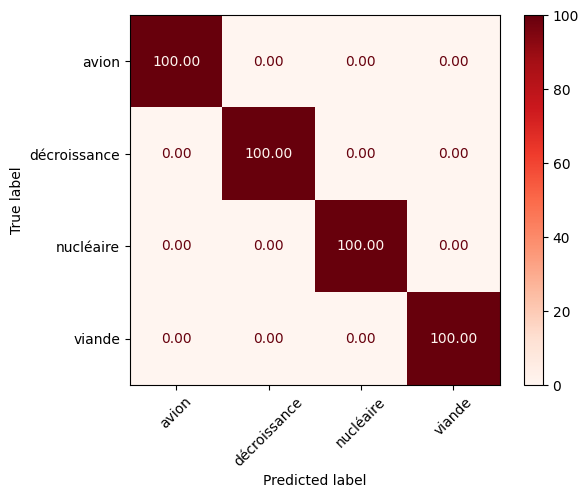

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate(model, test_data):
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

            all_predictions.extend(output.argmax(dim=1).cpu().numpy())
            all_labels.extend(test_label.cpu().numpy())

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

    target_names = ['avion', 'décroissance', 'nucléaire', 'viande']
    report = classification_report(all_labels, all_predictions, target_names=target_names)
    print("Classification Report:")
    print(report)

    # Plot the confusion matrix with class names and values as percentages
    cm = confusion_matrix(all_labels, all_predictions, normalize='true')  # Normalize the confusion matrix
    cm_percent = cm * 100  # Convert values to percentages
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=target_names)
    disp.plot(cmap=plt.cm.Reds, values_format='.2f')
    plt.xticks(rotation=45)
    plt.show()

    # Return the test data and labels
    return test_data['Text'].tolist(), all_labels

# Assuming you have imported your model and df_test properly
X_test_text, Y_test = evaluate(model, df_test)


In [ ]:
#save my model
torch.save(model.state_dict(), 'trained_model.pth')

Partie 4 : Attribution score for predected target

In [ ]:
#Instanciation du modèle avec les poids saved

class CamembertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(CamembertClassifier, self).__init__()

        self.bert = CamembertModel.from_pretrained('camembert-base')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 4)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask = None):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

model = CamembertClassifier()
model.load_state_dict(torch.load('/content/trained_model.pth', map_location=torch.device('cpu')))
model.eval()

CamembertClassifier(
  (bert): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (

In [ ]:
# Define model output
def model_output(inputs):
    return model(inputs)

# Define model input
model_input = model.bert.embeddings

In [ ]:
#Une classe de captum pour calculer integred gradient pour une entrée donnée pour donner l'importance de chaque token de notre entrée pour comprendre les prédiction du modèle
lig = LayerIntegratedGradients(model_output, model_input) # calcul de integred gradiend entre la baseline et l'entrée

In [ ]:
#La préparation de Imput data et baseline data
def construct_input_and_baseline(text):

    max_length = 250
    baseline_token_id = tokenizer.pad_token_id
    sep_token_id = tokenizer.sep_token_id
    cls_token_id = tokenizer.cls_token_id
    text = convert_emoji_to_text(text)

    text_ids = tokenizer.encode(text, max_length=max_length, truncation=True, add_special_tokens=False)

    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    token_list = tokenizer.convert_ids_to_tokens(input_ids)


    baseline_input_ids = [cls_token_id] + [baseline_token_id] * len(text_ids) + [sep_token_id]
    return torch.tensor([input_ids], device='cpu'), torch.tensor([baseline_input_ids], device='cpu'), token_list

text = "viande est mal pour environnement"
input_ids, baseline_input_ids, all_tokens = construct_input_and_baseline(text)

print(f'original text: {input_ids}')
print(f'baseline text: {baseline_input_ids}')

original text: tensor([[   5, 3952,   30,  295,   24, 1898,    6]])
baseline text: tensor([[5, 1, 1, 1, 1, 1, 6]])


In [ ]:
#La normalisation des scores d'attribution
def summarize_attributions(attributions):

    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions).tolist()

    return attributions

In [ ]:
#La mesure des score d'attribution par rapport à la classe prédite par le modèle
def get_attribution_scores_for_predicted_class(sentences):
    class_labels = ['avion', 'décroissance', 'nucléaire', 'viande']

    attribution_scores_by_sentence = {}

    for text in sentences:
        input_ids, baseline_input_ids, all_tokens = construct_input_and_baseline(text)

        model_output = model(input_ids)
        predicted_index = torch.argmax(model_output[0]).item()
        predicted_class = class_labels[predicted_index]

        attribution_scores_for_predicted_class = {}

        target_class = predicted_class

        target_index = class_labels.index(target_class)
        attributions, delta = lig.attribute(inputs=input_ids, baselines=baseline_input_ids, target=target_index, return_convergence_delta=True)

        #attributions_sum = attributions.sum(dim=-1).squeeze().tolist()
        attributions_sum = summarize_attributions(attributions)

        target_score = sum(attributions_sum)

        attribution_scores_for_predicted_class = {
            "word_attributions": attributions_sum,
            "pred_prob": torch.max(model_output[0]).item(),
            "pred_class": predicted_class,
            "true_class": class_labels[predicted_index],
            "attr_class": text,
            "attr_score": target_score,
            "raw_input_ids": all_tokens,
            "convergence_score": delta
        }

        attribution_scores_by_sentence[text] = attribution_scores_for_predicted_class

    return attribution_scores_by_sentence

#La visualisation d'influence de chaque token de l'Imput

def visualize_attributions_for_predicted_class(text):
    attribution_scores = get_attribution_scores_for_predicted_class([text])

    class_labels = ['avion', 'décroissance', 'nucléaire', 'viande']

    original_prob = attribution_scores[text]['pred_prob']

    target_score = attribution_scores[text]['attr_score']

    predicted_vis = viz.VisualizationDataRecord(
        word_attributions=attribution_scores[text]['word_attributions'],
        pred_prob=original_prob,
        pred_class=attribution_scores[text]['pred_class'],
        true_class=attribution_scores[text]['true_class'],
        attr_class=attribution_scores[text]['attr_class'],
        attr_score=target_score,
        raw_input_ids=attribution_scores[text]['raw_input_ids'],
        convergence_score=attribution_scores[text]['convergence_score']
    )

    viz.visualize_text([predicted_vis])

In [ ]:
text="croissance du PIB"
visualize_attributions_for_predicted_class(text)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
décroissance,décroissance (2.76),croissance du PIB,-0.86,#s ▁croissance ▁PIB #/s


In [ ]:
text = "En 2014, EDF devait vendre 25% de sa production nucl\u00e9aire \u00e0 prix brad\u00e9, aujourd\u2019hui c\u2019est 40%. Proglio raconte comment le p\u2026"
visualize_attributions_for_predicted_class(text)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
nucléaire,nucléaire (4.57),"En 2014, EDF devait vendre 25% de sa production nucléaire à prix bradé, aujourd’hui c’est 40%. Proglio raconte comment le p…",2.51,#s ▁En ▁EDF ▁devait ▁vendre ▁sa ▁production ▁nu cle aire ▁a ▁prix ▁brad e ▁aujourd hui ▁c est ▁Pro glio ▁raconte ▁comment ▁p #/s


Partie 5 : Attribution score for each target

In [ ]:
#Le calcule des scores d'attribution par rapport à chaque target (le calcul est fait en considérant que le modèle prédit le target en question)
def get_attribution_scores_for_all_targets(sentences):
    class_labels = ['avion', 'décroissance', 'nucléaire', 'viande']

    attribution_scores_by_sentence = {}

    for text in sentences:
        input_ids, baseline_input_ids, all_tokens = construct_input_and_baseline(text)

        model_output = model(input_ids)
        predicted_index = torch.argmax(model_output[0]).item()
        predicted_class = class_labels[predicted_index]

        attribution_scores_by_target = {}

        for target_class in class_labels:
            target_index = class_labels.index(target_class)
            attributions, delta = lig.attribute(inputs=input_ids, baselines=baseline_input_ids, target=target_index, return_convergence_delta=True)

            #attributions_sum = attributions.sum(dim=-1).squeeze().tolist()
            attributions_sum = summarize_attributions(attributions)

            target_score = sum(attributions_sum)

            attribution_scores_by_target[target_class] = {
                "word_attributions": attributions_sum,
                "pred_prob": torch.max(model_output[0]).item(),
                "pred_class": predicted_class,
                "true_class": class_labels[predicted_index],
                "attr_class": text,
                "attr_score": target_score,
                "raw_input_ids": all_tokens,
                "convergence_score": delta
            }

        attribution_scores_by_sentence[text] = attribution_scores_by_target

    return attribution_scores_by_sentence

#Ecrire les score d'attribution de chaque token par rapport à chaque target
def display_attribution_scores(scores):
    for sentence, target_scores in scores.items():
        print("Sentence:", sentence)
        for target_class, scores_dict in target_scores.items():
            print("Target Class:", target_class)
            print("Token\t\tAttribution Score")
            print("--------------------------")
            word_attributions = scores_dict["word_attributions"]
            for token, score in zip(scores_dict["raw_input_ids"], word_attributions):
                print(f"{token}\t\t{score:.4f}")
            for bigram_key, bigram_scores in scores_dict.items():
                if bigram_key.startswith("bigram_"):
                    bigram_tokens = bigram_key.replace("bigram_", "")
                    print(f"{bigram_tokens}\t\t{bigram_scores:.4f}")
            for trigram_key, trigram_scores in scores_dict.items():
                if trigram_key.startswith("trigram_"):
                    trigram_tokens = trigram_key.replace("trigram_", "")
                    print(f"{trigram_tokens}\t\t{trigram_scores:.4f}")
            print("\nPredicted Class:", scores_dict["pred_class"])
            print("True Class:", scores_dict["true_class"])
            print("Predicted Probability:", scores_dict["pred_prob"])
            print("Target Attribution Score:", scores_dict["attr_score"])
            print("\n" + "="*50 + "\n")

In [ ]:
#Exemple
sentences = ["les abattoirs dans la compagne", "l'avion pollue beaucoup", "l'énergie nucléaire"]
true_class = 0
attribution_scores = get_attribution_scores_for_all_targets(sentences)
display_attribution_scores(attribution_scores)

Sentence: les abattoirs dans la compagne
Target Class: avion
Token		Attribution Score
--------------------------
<s>		0.0000
▁		-0.2810
abattoir		-0.1018
s		0.7223
▁dans		0.5076
▁compagne		0.3618
</s>		-0.0206

Predicted Class: viande
True Class: viande
Predicted Probability: 4.396393299102783
Target Attribution Score: tensor(1.1882, dtype=torch.float64)


Target Class: décroissance
Token		Attribution Score
--------------------------
<s>		0.0000
▁		0.4552
abattoir		0.0564
s		0.6521
▁dans		-0.5228
▁compagne		-0.2489
</s>		0.1707

Predicted Class: viande
True Class: viande
Predicted Probability: 4.396393299102783
Target Attribution Score: tensor(0.5626, dtype=torch.float64)


Target Class: nucléaire
Token		Attribution Score
--------------------------
<s>		0.0000
▁		-0.7110
abattoir		-0.3723
s		0.4636
▁dans		-0.1877
▁compagne		0.3144
</s>		-0.0829

Predicted Class: viande
True Class: viande
Predicted Probability: 4.396393299102783
Target Attribution Score: tensor(-0.5759, dtype=torch.floa

La visualisation de l'influence de chaque token par rapport au target spécifié


In [ ]:
def interpret_text_for_target(text, true_class, target_class):
    attribution_scores = get_attribution_scores_for_all_targets([text])

    class_labels = ['avion', 'décroissance', 'nucléaire', 'viande']

    original_prob = attribution_scores[text][class_labels[true_class]]['pred_prob']

    target_score = attribution_scores[text][target_class]['attr_score']

    target_vis = viz.VisualizationDataRecord(
        word_attributions=attribution_scores[text][target_class]['word_attributions'],
        pred_prob=original_prob,
        pred_class=attribution_scores[text][class_labels[true_class]]['pred_class'],
        true_class=class_labels[true_class],
        attr_class=attribution_scores[text][target_class]['attr_class'],
        attr_score=target_score,
        raw_input_ids=attribution_scores[text][target_class]['raw_input_ids'],
        convergence_score=attribution_scores[text][target_class]['convergence_score']
    )

    viz.visualize_text([target_vis])

In [ ]:
#Exemple
input_text = "augmentation nombre avion"
true_class = 0
target_class = 'avion'

interpret_text_for_target(input_text, true_class, target_class)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
avion,avion (3.58),augmentation nombre avion,1.48,#s ▁augmentation ▁nombre ▁avion #/s


In [ ]:
#Exemple
input_text = "augmentation nombre avion"
true_class = 0
target_class = 'viande'

interpret_text_for_target(input_text, true_class, target_class)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
avion,avion (3.58),augmentation nombre avion,-1.79,#s ▁augmentation ▁nombre ▁avion #/s


In [ ]:
#Exemple
input_text = "augmentation nombre avion"
true_class = 0
target_class = 'nucléaire'

interpret_text_for_target(input_text, true_class, target_class)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
avion,avion (3.58),augmentation nombre avion,-0.11,#s ▁augmentation ▁nombre ▁avion #/s


In [ ]:
#Exemple
input_text = "augmentation nombre avion"
true_class = 0
target_class = 'décroissance'

interpret_text_for_target(input_text, true_class, target_class)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
avion,avion (3.58),augmentation nombre avion,-0.81,#s ▁augmentation ▁nombre ▁avion #/s


Partie 6 : Attribution score for bigramm and trigramm, Création des clusters


In [ ]:
# Le calcule des score d'attribution par rapport aux différents target pour les unigram, bigram et trigram

def get_attribution_scores_for_all_targets(sentences):
    class_labels = ['avion', 'décroissance', 'nucléaire', 'viande']

    attribution_scores_by_sentence = {}

    for text in sentences:
        input_ids, baseline_input_ids, all_tokens = construct_input_and_baseline(text)

        model_output = model(input_ids)
        predicted_index = torch.argmax(model_output[0]).item()
        predicted_class = class_labels[predicted_index]

        attribution_scores_by_target = {}

        for target_class in class_labels:
            target_index = class_labels.index(target_class)
            attributions, delta = lig.attribute(inputs=input_ids, baselines=baseline_input_ids, target=target_index, return_convergence_delta=True)

            #attributions_sum = attributions.sum(dim=-1).squeeze().tolist()
            attributions_sum = summarize_attributions(attributions).tolist()

            target_score = sum(attributions_sum)

            bigram_attributions_sum = []
            for i in range(len(attributions_sum) - 1):
                bigram_score = attributions_sum[i] + attributions_sum[i + 1]
                bigram_attributions_sum.append(bigram_score)

            trigram_attributions_sum = []
            for i in range(len(attributions_sum) - 2):
                trigram_score = attributions_sum[i] + attributions_sum[i + 1] + attributions_sum[i + 2]
                trigram_attributions_sum.append(trigram_score)

            attribution_scores_by_target[target_class] = {
                "word_attributions": attributions_sum,
                "bigram_attributions": bigram_attributions_sum,
                "trigram_attributions": trigram_attributions_sum,
                "pred_prob": torch.max(model_output[0]).item(),
                "pred_class": predicted_class,
                "true_class": class_labels[predicted_index],
                "attr_class": text,
                "attr_score": target_score,
                "raw_input_ids": all_tokens,
                "convergence_score": delta
            }

        attribution_scores_by_sentence[text] = attribution_scores_by_target

    return attribution_scores_by_sentence
#Ecrire les score d'attribution de chaque unigram, biram et trigram par rapport à chaque target

def display_attribution_scores(scores):
    for sentence, target_scores in scores.items():
        print("Sentence:", sentence)
        for target_class, scores_dict in target_scores.items():
            print("Target Class:", target_class)
            print("Token\t\tAttribution Score")
            print("--------------------------")
            word_attributions = scores_dict["word_attributions"]
            for token, score in zip(scores_dict["raw_input_ids"], word_attributions):
                print(f"{token}\t\t{score:.4f}")

            print("\nBigram\t\tAttribution Score")
            print("--------------------------")
            bigram_attributions = scores_dict.get("bigram_attributions", [])
            bigram_tokens = [f"{token} {scores_dict['raw_input_ids'][i+1]}" for i, token in enumerate(scores_dict["raw_input_ids"][:-1])]
            for token, score in zip(bigram_tokens, bigram_attributions):
                print(f"{token}\t\t{score:.4f}")

            print("\nTrigram\t\tAttribution Score")  # Add this section for displaying trigram attributions
            print("--------------------------")
            trigram_attributions = scores_dict.get("trigram_attributions", [])
            trigram_tokens = [f"{token} {scores_dict['raw_input_ids'][i+1]} {scores_dict['raw_input_ids'][i+2]}" for i, token in enumerate(scores_dict["raw_input_ids"][:-2])]
            for token, score in zip(trigram_tokens, trigram_attributions):
                print(f"{token}\t\t{score:.4f}")

            print("\nPredicted Class:", scores_dict["pred_class"])
            print("True Class:", scores_dict["true_class"])
            print("Predicted Probability:", scores_dict["pred_prob"])
            print("Target Attribution Score:", scores_dict["attr_score"])
            print("\n" + "="*50 + "\n")



In [ ]:
#Exemple
#sentences = ["production de viande dans des abattoir", "l'avion pollue beaucoup l'air", "l'énergie nucléaire permet de produire électricité"]
sentences = df_test['Text'].tolist()

attribution_scores = get_attribution_scores_for_all_targets(sentences)
display_attribution_scores(attribution_scores)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
▁sur ▁car go		-1.0536
▁car go s		-1.3384
go s ▁pro		-0.9110
s ▁pro pulse		-0.5635
▁pro pulse s		-0.3444
pulse s ▁au		-0.2303
s ▁au ▁fu		-0.1483
▁au ▁fu e		0.0169
▁fu e </s>		0.0293

Predicted Class: nucléaire
True Class: nucléaire
Predicted Probability: 4.629717826843262
Target Attribution Score: -0.9601081446310711


Sentence: RT @AlterKapitae: Super interview de @VinczeDegrowth
"Nous nous sommes enfermés dans la religion de la croissance". Ecoutons-le pour en sor…
Target Class: avion
Token		Attribution Score
--------------------------
<s>		0.0000
▁RT		-0.7209
▁Al		-0.0007
ter		0.0134
K		-0.0703
ap		-0.0954
ita		-0.0495
e		-0.0347
▁Super		0.0114
▁interview		-0.0242
▁Vin		0.0246
c		0.0435
ze		0.0294
De		-0.0123
g		-0.0454
row		-0.0362
th		-0.0186
▁sommes		-0.0065
▁en		-0.0441
ferme		-0.0088
s		-0.0573
▁dans		0.0072
▁religion		-0.0302
▁croissance		0.0087
▁E		-0.1160
cout		-0.2106
ons		-0.2431
-		-0.1438
le		-0

In [ ]:
#Enregistrer les score d'attribution des différent unigral, bigram et trigram dans un fichier json pour les différents targets

def convert_to_native_python_types(data):
    if isinstance(data, dict):
        return {key: convert_to_native_python_types(value) for key, value in data.items()}
    elif isinstance(data, list):
        return [convert_to_native_python_types(element) for element in data]
    elif isinstance(data, tuple):
        return tuple(convert_to_native_python_types(element) for element in data)
    elif isinstance(data, set):
        return {convert_to_native_python_types(element) for element in data}
    elif isinstance(data, torch.Tensor):
        return data.tolist()
    else:
        return data

def save_attribution_scores_to_json(attribution_scores, file_path):
    output_data = defaultdict(lambda: defaultdict(dict))

    for sentence, target_scores in attribution_scores.items():
        for target_class, scores_dict in target_scores.items():
            output_data[sentence][target_class]["tokens"] = scores_dict["raw_input_ids"]
            output_data[sentence][target_class]["word_attributions"] = scores_dict["word_attributions"]

            bigram_tokens = [f"{token} {scores_dict['raw_input_ids'][i+1]}" for i, token in enumerate(scores_dict["raw_input_ids"][:-1])]
            bigram_scores = scores_dict.get("bigram_attributions", [])
            output_data[sentence][target_class]["bigrams"] = bigram_tokens
            output_data[sentence][target_class]["bigram_attributions"] = bigram_scores

            trigram_tokens = [f"{token} {scores_dict['raw_input_ids'][i+1]} {scores_dict['raw_input_ids'][i+2]}" for i, token in enumerate(scores_dict["raw_input_ids"][:-2])]
            trigram_scores = scores_dict.get("trigram_attributions", [])
            output_data[sentence][target_class]["trigrams"] = trigram_tokens
            output_data[sentence][target_class]["trigram_attributions"] = trigram_scores

            # Add other fields if needed, such as "pred_prob", "pred_class", etc.

    with open(file_path, "w") as file:
        json.dump(output_data, file)

# Assuming you already have the following variables defined:
# attribution_scores: The output of the get_attribution_scores_for_all_targets function

# Define the file path for saving the attribution scores
attribution_scores_file_path = "/content/saved_attribution_scores.json"

# Save the attribution scores to a JSON file in the desired format
save_attribution_scores_to_json(attribution_scores, attribution_scores_file_path)
print("Saved Attribution Scores to file:", attribution_scores_file_path)

Saved Attribution Scores to file: /content/saved_attribution_scores.json


In [ ]:
#La fonction retourne pour chaque token le meilleur score d'attribution avec le target correspondent
def create_clusters(scores):
    class_labels = ['avion', 'décroissance', 'nucléaire', 'viande']
    clusters = {token: {"target_class": None, "token_score": -float("inf")} for _, target_scores in scores.items() for _, scores_dict in target_scores.items() for token in scores_dict["raw_input_ids"]}

    for sentence, target_scores in scores.items():
        for target_class, scores_dict in target_scores.items():
            word_attributions = scores_dict["word_attributions"]

            for i, token in enumerate(scores_dict["raw_input_ids"]):
                token_score = word_attributions[i]

                if token_score > clusters[token]["token_score"]:
                    clusters[token]["token_score"] = token_score
                    clusters[token]["target_class"] = target_class

    return clusters
def display_clusters(clusters):
    for token, info in clusters.items():
        if info["token_score"] > 0:
            print(f"Token: {token}")
            print("Best Target Class:", info["target_class"])
            print("Attribution Score:", info["token_score"])
            print("="*50)

clusters = create_clusters(attribution_scores)

display_clusters(clusters)

Token: ▁
Best Target Class: viande
Attribution Score: 0.3367408766956855
Token: ern
Best Target Class: nucléaire
Attribution Score: 0.3441451163973267
Token: est
Best Target Class: avion
Attribution Score: 0.38698257721523777
Token: _
Best Target Class: décroissance
Attribution Score: 0.4405221841436491
Token: pl
Best Target Class: décroissance
Attribution Score: 0.07137745013910402
Token: on
Best Target Class: avion
Attribution Score: 0.4901638676481372
Token: che
Best Target Class: viande
Attribution Score: 0.025881656949577496
Token: ▁Cette
Best Target Class: viande
Attribution Score: 0.06883225755105471
Token: ▁industrie
Best Target Class: viande
Attribution Score: 0.09619292587870283
Token: ▁fonctionne
Best Target Class: avion
Attribution Score: 0.053586959316772036
Token: ▁sur
Best Target Class: viande
Attribution Score: 0.7293678373662413
Token: ▁l
Best Target Class: viande
Attribution Score: 0.35000416113231664
Token: '
Best Target Class: viande
Attribution Score: 0.36568300749

In [ ]:
# Regrouper les tokens de la fonction précédente qui appartient au meme target dans un meme cluster correspendant à ce target
def create_target_clusters(clusters):
    class_labels = ['avion', 'décroissance', 'nucléaire', 'viande']
    target_clusters = {target: {"tokens": [], "scores": []} for target in class_labels}

    for token, info in clusters.items():
        if token not in ["<s>", "</s>"]:
            target_class = info["target_class"]
            if target_class:
                target_clusters[target_class]["tokens"].append(token)
                target_clusters[target_class]["scores"].append(info["token_score"])

    for target, scores_info in target_clusters.items():
        tokens_scores = zip(scores_info["tokens"], scores_info["scores"])
        sorted_tokens_scores = sorted(tokens_scores, key=lambda x: x[1], reverse=True)
        target_clusters[target] = dict(sorted_tokens_scores)

    return target_clusters

def display_target_clusters(target_clusters):
    for target, tokens_scores_dict in target_clusters.items():
        print(f"Cluster for Target Class: {target}")
        for token, score in tokens_scores_dict.items():
            print(f"Token: {token}")
            print("Attribution Score:", score)
            print("="*50)
#Chaque cluster est représenté sous la forme d'un dictionnaire avec deux listes tokens et scores
def save_clusters_to_dict(target_clusters):
    saved_clusters = {}
    for target, tokens_scores_dict in target_clusters.items():
        cluster_dict = {
            "tokens": list(tokens_scores_dict.keys()),
            "scores": list(tokens_scores_dict.values())
        }
        saved_clusters[target] = cluster_dict
    return saved_clusters


# Create target clusters
target_clusters = create_target_clusters(clusters)

# Display target clusters
display_target_clusters(target_clusters)

# Save clusters to a dictionary
saved_clusters_dict = save_clusters_to_dict(target_clusters)
print("Saved Clusters:")
print(saved_clusters_dict)


Cluster for Target Class: avion
Token: ▁Pi
Attribution Score: 0.984415388522172
Token: ux
Attribution Score: 0.9390636837835316
Token: rge
Attribution Score: 0.9318541408843573
Token: ▁demande
Attribution Score: 0.8928369788996585
Token: activiste
Attribution Score: 0.8740662152849973
Token: lia
Attribution Score: 0.807171431922697
Token: ▁car
Attribution Score: 0.651550784584209
Token: ▁Air
Attribution Score: 0.6397076525821597
Token: OI
Attribution Score: 0.5778369538319422
Token: ▁I
Attribution Score: 0.5400130779710037
Token: go
Attribution Score: 0.5211446040382975
Token: iere
Attribution Score: 0.5034091344019415
Token: on
Attribution Score: 0.4901638676481372
Token: au
Attribution Score: 0.47247978082866315
Token: iez
Attribution Score: 0.4711412322754204
Token: ▁A
Attribution Score: 0.45625158460972054
Token: ▁pas
Attribution Score: 0.4211286230168977
Token: est
Attribution Score: 0.38698257721523777
Token: tique
Attribution Score: 0.3637493038602273
Token: er
Attribution Score

In [ ]:
saved_clusters_dict = save_clusters_to_dict(target_clusters)
file_path = "/content/saved_clusters.json"
with open(file_path, "w") as file:
    json.dump(saved_clusters_dict, file)
print("Saved Clusters to file:", file_path)

Saved Clusters to file: /content/saved_clusters.json


In [ ]:
#Le calcul des scores d'attribution pour chaque unigram, bigram et trigram par rapport à chaque target
#La fonction retourne un dictionnaire qui contient les phrases comme clé et valeur un autre dictionnaire qui contient les score d'attribution
#des tokens de la phrase en question pour chaque target
def get_attribution_scores_for_all_targets(sentences):
    class_labels = ['avion', 'décroissance', 'nucléaire', 'viande']

    # Initialize a dictionary to store attribution scores for each target class and sentence
    attribution_scores_by_sentence = {}

    for text in sentences:
        # Construct input and baseline for the given text
        input_ids, baseline_input_ids, all_tokens = construct_input_and_baseline(text)

        # Get model predictions for the given text
        model_output = model(input_ids)
        predicted_index = torch.argmax(model_output[0]).item()
        predicted_class = class_labels[predicted_index]

        # Initialize a dictionary to store attribution scores for each target class in the current sentence
        attribution_scores_by_target = {}

        for target_class in class_labels:
            target_index = class_labels.index(target_class)
            attributions, delta = lig.attribute(inputs=input_ids, baselines=baseline_input_ids, target=target_index, return_convergence_delta=True)

            # Summarize the attributions across tokens (modify this part based on your summarize_attributions function)
           # attributions_sum = attributions.sum(dim=-1).squeeze().tolist()
            attributions_sum = summarize_attributions(attributions).tolist()

            # Calculate attribution score for the current target class
            target_score = sum(attributions_sum)

            # Calculate bigram scores
            bigram_scores = [attributions_sum[i] + attributions_sum[i+1] for i in range(len(attributions_sum) - 1)]

            # Calculate trigram scores
            trigram_scores = [attributions_sum[i] + attributions_sum[i+1] + attributions_sum[i+2] for i in range(len(attributions_sum) - 2)]

            # Store the attribution scores in the dictionary for the current target class
            attribution_scores_by_target[target_class] = {
                "word_attributions": attributions_sum,
                "bigram_scores": bigram_scores,
                "trigram_scores": trigram_scores,
                "pred_prob": torch.max(model_output[0]).item(),
                "pred_class": predicted_class,
                "true_class": class_labels[predicted_index],
                "attr_class": text,
                "attr_score": target_score,
                "raw_input_ids": all_tokens,
                "convergence_score": delta
            }

        # Store the attribution scores for the current sentence in the main dictionary
        attribution_scores_by_sentence[text] = attribution_scores_by_target

    return attribution_scores_by_sentence

def display_attribution_scores(scores):
    for sentence, target_scores in scores.items():
        print("Sentence:", sentence)
        for target_class, scores_dict in target_scores.items():
            print("Target Class:", target_class)

            # Display token scores
            print("Token\t\tToken Score")
            print("--------------------------")
            word_attributions = scores_dict["word_attributions"]
            for token, score in zip(scores_dict["raw_input_ids"], word_attributions):
                print(f"{token}\t\t{score:.4f}")

            # Display bigram scores
            print("\nBigram\t\tBigram Score")
            print("--------------------------")
            bigram_attributions = scores_dict["bigram_scores"]
            bigram_tokens = [f"{scores_dict['raw_input_ids'][i]} {scores_dict['raw_input_ids'][i+1]}" for i in range(len(scores_dict["raw_input_ids"]) - 1)]
            for token, score in zip(bigram_tokens, bigram_attributions):
                print(f"{token}\t\t{score:.4f}")

            # Display trigram scores
            print("\nTrigram\t\tTrigram Score")
            print("--------------------------")
            trigram_attributions = scores_dict["trigram_scores"]
            trigram_tokens = [f"{scores_dict['raw_input_ids'][i]} {scores_dict['raw_input_ids'][i+1]} {scores_dict['raw_input_ids'][i+2]}" for i in range(len(scores_dict["raw_input_ids"]) - 2)]
            for token, score in zip(trigram_tokens, trigram_attributions):
                print(f"{token}\t\t{score:.4f}")

            print("\nPredicted Class:", scores_dict["pred_class"])
            print("True Class:", scores_dict["true_class"])
            print("Predicted Probability:", scores_dict["pred_prob"])
            print("Target Attribution Score:", scores_dict["attr_score"])
            print("\n" + "="*50 + "\n")

# Example sentences and true class
sentences = ["croissance production de viande", "l'avion pollue beaucoup", "l'énergie nucléaire"]
true_class = 0

# Get attribution scores
attribution_scores = get_attribution_scores_for_all_targets(sentences)

# Display attribution scores
display_attribution_scores(attribution_scores)


Sentence: croissance production de viande
Target Class: avion
Token		Token Score
--------------------------
<s>		nan
▁croissance		nan
▁production		nan
▁viande		nan
</s>		nan

Bigram		Bigram Score
--------------------------
<s> ▁croissance		nan
▁croissance ▁production		nan
▁production ▁viande		nan
▁viande </s>		nan

Trigram		Trigram Score
--------------------------
<s> ▁croissance ▁production		nan
▁croissance ▁production ▁viande		nan
▁production ▁viande </s>		nan

Predicted Class: viande
True Class: viande
Predicted Probability: 4.413150787353516
Target Attribution Score: nan


Target Class: décroissance
Token		Token Score
--------------------------
<s>		0.0000
▁croissance		0.8801
▁production		0.3766
▁viande		-0.1096
</s>		-0.2676

Bigram		Bigram Score
--------------------------
<s> ▁croissance		0.8801
▁croissance ▁production		1.2567
▁production ▁viande		0.2670
▁viande </s>		-0.3771

Trigram		Trigram Score
--------------------------
<s> ▁croissance ▁production		1.2567
▁croissance ▁produ

In [ ]:
#La fonction crée des clusters qui contient les unigram, bigram et trigram avec le plus grand score d'attribution
def create_target_clusters(scores):
    class_labels = ['avion', 'décroissance', 'nucléaire', 'viande']

    target_clusters = {target: {"tokens": [], "bigrams": [], "trigrams": []} for target in class_labels}

    for sentence, target_scores in scores.items():
        for target_class, scores_dict in target_scores.items():
            word_attributions = scores_dict["word_attributions"]
            bigram_attributions = scores_dict["bigram_scores"]
            trigram_attributions = scores_dict["trigram_scores"]

            for i, (token, token_score) in enumerate(zip(scores_dict["raw_input_ids"], word_attributions)):
                if token_score > 0:
                    # Determine the corresponding target class with the highest score for this token
                    best_target = max(target_scores.keys(), key=lambda target: target_scores[target]["word_attributions"][i])
                    if best_target == target_class:
                        target_clusters[target_class]["tokens"].append((token, token_score))

            for i in range(len(scores_dict["raw_input_ids"]) - 1):
                bigram_token = f"{scores_dict['raw_input_ids'][i]} {scores_dict['raw_input_ids'][i+1]}"
                bigram_score = bigram_attributions[i]
                if bigram_score > 0:
                    best_target = max(target_scores.keys(), key=lambda target: target_scores[target]["bigram_scores"][i])
                    if best_target == target_class:
                        target_clusters[target_class]["bigrams"].append((bigram_token, bigram_score))

            for i in range(len(scores_dict["raw_input_ids"]) - 2):
                trigram_token = f"{scores_dict['raw_input_ids'][i]} {scores_dict['raw_input_ids'][i+1]} {scores_dict['raw_input_ids'][i+2]}"
                trigram_score = trigram_attributions[i]
                if trigram_score > 0:
                    best_target = max(target_scores.keys(), key=lambda target: target_scores[target]["trigram_scores"][i])
                    if best_target == target_class:
                        target_clusters[target_class]["trigrams"].append((trigram_token, trigram_score))

    return target_clusters

# Example sentences and true class
#sentences = ["augmentation production de viande", "l'avion pollue beaucoup", "l'énergie nucléaire"]
sentences = df_test['Text'].tolist()
true_class = 0

# Get attribution scores
attribution_scores = get_attribution_scores_for_all_targets(sentences)

# Create target clusters
target_clusters = create_target_clusters(attribution_scores)

# Save clusters to a JSON file
result_dict = {}
for target, data in target_clusters.items():
    result_dict[target] = {
        "tokens": [{"token": token, "score": score} for token, score in sorted(data["tokens"], key=lambda x: x[1], reverse=True)],
        "bigrams": [{"bigram": bigram, "score": score} for bigram, score in sorted(data["bigrams"], key=lambda x: x[1], reverse=True)],
        "trigrams": [{"trigram": trigram, "score": score} for trigram, score in sorted(data["trigrams"], key=lambda x: x[1], reverse=True)]
    }

# Save the result to a JSON file
import json
with open("target_clusters.json", "w") as json_file:
    json.dump(result_dict, json_file, indent=4)

print("Saved target clusters to 'target_clusters.json'")


Saved target clusters to 'target_clusters.json'


In [ ]:
import json

# Function to create clusters containing unigrams, bigrams, and trigrams with the most negative attribution score
def create_negative_score_clusters(scores):
    class_labels = ['avion', 'décroissance', 'nucléaire', 'viande']

    negative_score_clusters = {target: {"tokens": [], "bigrams": [], "trigrams": []} for target in class_labels}

    for sentence, target_scores in scores.items():
        for target_class, scores_dict in target_scores.items():
            word_attributions = scores_dict["word_attributions"]
            bigram_attributions = scores_dict["bigram_scores"]
            trigram_attributions = scores_dict["trigram_scores"]

            for i, (token, token_score) in enumerate(zip(scores_dict["raw_input_ids"], word_attributions)):
                token = token.lstrip('\u2581')  # Remove the character from the beginning
                if token_score < 0:
                    # Determine the corresponding target class with the most negative score for this token
                    worst_target = min(target_scores.keys(), key=lambda target: target_scores[target]["word_attributions"][i])
                    if worst_target == target_class:
                        negative_score_clusters[target_class]["tokens"].append((token, token_score))

            for i in range(len(scores_dict["raw_input_ids"]) - 1):
                bigram_token = f"{scores_dict['raw_input_ids'][i]} {scores_dict['raw_input_ids'][i+1]}"
                bigram_token = bigram_token.lstrip('\u2581')  # Remove the character from the beginning
                bigram_score = bigram_attributions[i]
                if bigram_score < 0:
                    worst_target = min(target_scores.keys(), key=lambda target: target_scores[target]["bigram_scores"][i])
                    if worst_target == target_class:
                        negative_score_clusters[target_class]["bigrams"].append((bigram_token, bigram_score))

            for i in range(len(scores_dict["raw_input_ids"]) - 2):
                trigram_token = f"{scores_dict['raw_input_ids'][i]} {scores_dict['raw_input_ids'][i+1]} {scores_dict['raw_input_ids'][i+2]}"
                trigram_token = trigram_token.lstrip('\u2581')  # Remove the character from the beginning
                trigram_score = trigram_attributions[i]
                if trigram_score < 0:
                    worst_target = min(target_scores.keys(), key=lambda target: target_scores[target]["trigram_scores"][i])
                    if worst_target == target_class:
                        negative_score_clusters[target_class]["trigrams"].append((trigram_token, trigram_score))

    return negative_score_clusters

# Example sentences and true class
# sentences = ["augmentation production de viande", "l'avion pollue beaucoup", "l'énergie nucléaire"]
sentences = df_test['Text'].tolist()
true_class = 0

# Get attribution scores (you should define this function)
attribution_scores = get_attribution_scores_for_all_targets(sentences)

# Create negative score clusters
negative_score_clusters = create_negative_score_clusters(attribution_scores)

# Save clusters with negative scores to a JSON file
result_dict = {}
for target, data in negative_score_clusters.items():
    result_dict[target] = {
        "tokens": [{"token": token, "score": score} for token, score in sorted(data["tokens"], key=lambda x: x[1])],
        "bigrams": [{"bigram": bigram, "score": score} for bigram, score in sorted(data["bigrams"], key=lambda x: x[1])],
        "trigrams": [{"trigram": trigram, "score": score} for trigram, score in sorted(data["trigrams"], key=lambda x: x[1])]
    }

# Save the result to a JSON file
with open("negative_score_clusters.json", "w") as json_file:
    json.dump(result_dict, json_file, indent=4)

print("Saved negative score clusters to 'negative_score_clusters.json'")


Saved negative score clusters to 'negative_score_clusters.json'


In [ ]:
import json

# Function to create clusters containing unigrams, bigrams, and trigrams with the most negative attribution score
def create_negative_score_clusters(scores):
    class_labels = ['avion', 'décroissance', 'nucléaire', 'viande']

    negative_score_clusters = {target: {"tokens": [], "bigrams": [], "trigrams": []} for target in class_labels}

    for sentence, target_scores in scores.items():
        for target_class, scores_dict in target_scores.items():
            word_attributions = scores_dict["word_attributions"]
            bigram_attributions = scores_dict["bigram_scores"]
            trigram_attributions = scores_dict["trigram_scores"]

            for i, (token, token_score) in enumerate(zip(scores_dict["raw_input_ids"], word_attributions)):
                token = token.lstrip('\u2581')  # Remove the character from the beginning
                if token_score < 0:
                    # Determine the corresponding target class with the most negative score for this token
                    worst_target = min(target_scores.keys(), key=lambda target: target_scores[target]["word_attributions"][i])
                    if worst_target == target_class:
                        negative_score_clusters[target_class]["tokens"].append((token, token_score))

            for i in range(len(scores_dict["raw_input_ids"]) - 1):
                bigram_token = f"{scores_dict['raw_input_ids'][i]} {scores_dict['raw_input_ids'][i+1]}"
                bigram_token = bigram_token.lstrip('\u2581')  # Remove the character from the beginning
                bigram_score = bigram_attributions[i]
                if bigram_score < 0:
                    worst_target = min(target_scores.keys(), key=lambda target: target_scores[target]["bigram_scores"][i])
                    if worst_target == target_class:
                        negative_score_clusters[target_class]["bigrams"].append((bigram_token, bigram_score))

            for i in range(len(scores_dict["raw_input_ids"]) - 2):
                trigram_token = " ".join([scores_dict['raw_input_ids'][i], scores_dict['raw_input_ids'][i+1], scores_dict['raw_input_ids'][i+2]])
                trigram_token = trigram_token.lstrip('\u2581')  # Remove the character from the beginning
                trigram_score = trigram_attributions[i]
                if trigram_score < 0:
                    worst_target = min(target_scores.keys(), key=lambda target: target_scores[target]["trigram_scores"][i])
                    if worst_target == target_class:
                        negative_score_clusters[target_class]["trigrams"].append((trigram_token, trigram_score))

    return negative_score_clusters

# Example sentences and true class
# sentences = ["augmentation production de viande", "l'avion pollue beaucoup", "l'énergie nucléaire"]
sentences = df_test['Text'].tolist()
true_class = 0

# Get attribution scores (you should define this function)
attribution_scores = get_attribution_scores_for_all_targets(sentences)

# Create negative score clusters
negative_score_clusters = create_negative_score_clusters(attribution_scores)

# Save clusters with negative scores to a JSON file
result_dict = {}
for target, data in negative_score_clusters.items():
    result_dict[target] = {
        "tokens": [{"token": token, "score": score} for token, score in sorted(data["tokens"], key=lambda x: x[1])],
        "bigrams": [{"bigram": bigram, "score": score} for bigram, score in sorted(data["bigrams"], key=lambda x: x[1])],
        "trigrams": [{"trigram": trigram, "score": score} for trigram, score in sorted(data["trigrams"], key=lambda x: x[1])]
    }

# Save the result to a JSON file
with open("negative_score_clusters.json", "w") as json_file:
    json.dump(result_dict, json_file, indent=4)

print("Saved negative score clusters to 'negative_score_clusters.json'")


Saved negative score clusters to 'negative_score_clusters.json'
